# Resnet pytorch 구현 


**backborn code**

https://www.youtube.com/watch?v=DkNIBBBvcPs&t=15s

<br>
</br>


#### 추가 코드 참고
https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/ResNet18_CIFAR10_Train.ipynb
https://github.com/akamaster/pytorch_resnet_cifar10

In [187]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [188]:
%cd "/content/drive/MyDrive/DeepLearn_colab/Pytorch"

/content/drive/MyDrive/DeepLearn_colab/Pytorch


In [189]:
%pwd

'/content/drive/MyDrive/DeepLearn_colab/Pytorch'

## conv2d(input_channel,output_Channel.... )


input_channel, ouput_channel은 기존의 필터 개수라고 보면 된다    

padding은 zero padding 할 값을 설정 하는것이다 padding =0이면 valid이고 1이면 크기가 유지된다 물론 stride가 1일때를 가정한다 

<br>
</br>


주의점 : 

kernel_size, padding,stride, dilation은 tuple로 표현할수가 있다 

<br>
</br>


a tuple of two ints – in which case, the first int is used for the height dimension, and the second int for the width dimension

<br>
</br>



보통 이런 경우 non square kernel and unequal stride를 같이 쓰고 있는 상황에 padding 줘야 할때 tuple쓰는것 같고 의미는 같다 결국 zero padding 더해주는것이다 
 
<br>
</br>



공식 사이트 
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [190]:
# import modules 
import torch
import torch.nn as nn 
import torch.optim as optim
import os
import torchvision  
import torchvision.transforms as transforms 
import torch.backends.cudnn as cudnn


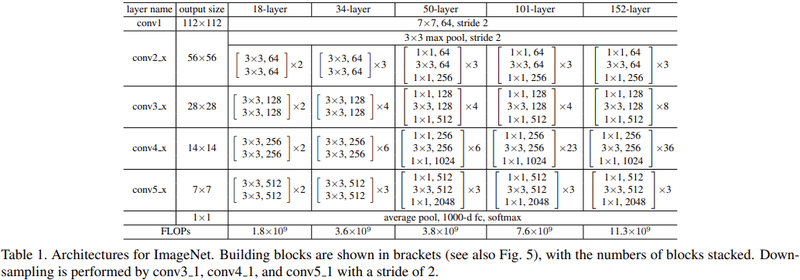

# ResNet 50 block 구성 


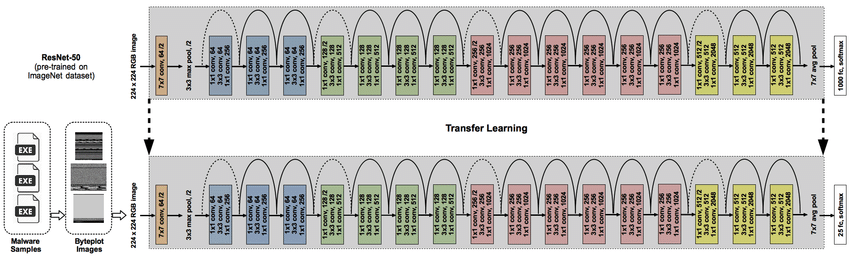

In [191]:

# Resnet impliementation 
# Programmed by Aladdin Persson <aladdin.persson at hotmail dot com>




# block 클래스 
"""
  
Resnet의 block 이다

  parameter 설명 

in_channels 
intermediate_channels : 중간 채널 
identity_downsample
  
"""
class block(nn.Module):  
    def __init__(self,in_channels,intermediate_channels,
               identity_downsample=None,stride=1,is_plain=False):
        
        # nn.Moduel 상속 
        super(block,self).__init__()
 
        self.expansion = 4 # 마지막 1*1*intermediate_channel * expansion 
        self.is_plain = is_plain

        # 1*1*3 -> 1*1*intermediate_channel 
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size = 1,
            stride =1,
            padding = 0,
            bias =False
            )

        # Batch Normalization 
        self.bn1 = nn.BatchNorm2d(intermediate_channels) # 

        # 3*3*itermediate_channels 
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride = stride,
            padding=1,
            bias = False
            )

        self.bn2 = nn.BatchNorm2d(intermediate_channels)
    

        # 1*1 intermediate_channels*expanstion 
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels*self.expansion,
            kernel_size =1,
            stride = 1,
            padding =0,
            bias = False
            )

        # Batch Normalization 

        #
        self.bn3 = nn.BatchNorm2d(intermediate_channels*self.expansion)

        self.relu = nn.ReLU()

        # identitpy
        self.identitiy_downsample = identity_downsample
        self.stride = stride 



    def forward(self,x):
        identity = x.clone() # x copy 

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        # identity_downsample이 
        if self.identitiy_downsample is not None:
            #
            identity = self.identitiy_downsample(identity) #sequnce 구조
        
        if(self.is_plain==False):

            x += identity # skip connection 


        x = self.relu(x)

        return x 



In [215]:
# resnet 34를 위한 block 
"""

"""
class BasicBlock(nn.Module):
    def __init__(self,in_channels,intermediate_channels,stride=1,identity_connection=None,is_plain=False):

        super(BasicBlock,self).__init__()
        self.is_plain = is_plain
        # 3*3 필터 3-> 64
        self.conv1 = nn.Conv2d(in_channels,intermediate_channels,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(intermediate_channels)

        # 3*3 64->64
        self.conv2 = nn.Conv2d(intermediate_channels,intermediate_channels,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.relu = nn.ReLU()

        self.identity_connection = identity_connection
        self.stride = stride 

    def forward(self,x):

        
        identity = x.clone() # x copy 

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        # plain 이면 작동 안함 
        if self.identity_connection is not None:
            #
            identity = self.identity_connection(identity)

        if(self.is_plain==False):
         
            x += identity # skip connection 
        
        x = self.relu(x)

        return x 








In [224]:
# Resnet implementation 

"""
34든 50이든 공통적으로 7*7*64로 시작하고 3*3 maxpool stride2f를 거친다 
plain net도 여기서 수행 할것이다 

parameter 설명 
다루는 데이터에 따라 num_class 달라야 한다 cifar10은 10개로 한다 



_layer 구성 할때 projection skip connection이 있다 
그때는 downsample을 해야 한다. 즉 identity downsample은 porjection skip connection이라고 볼수있다 
그리고 _basic _layer같은 경우에도 project skip connection이 필요 하다 그래서 kernel size가 1인것이고 stride가 2부터 적용이 되는것이다 


  
"""
class ResNet(nn.Module):
    def __init__(self,block,layers,image_channels,num_classes,is_34=False,is_plain=False):
        
        super(ResNet,self).__init__()

        self.in_channels = 64 # 처음 64 channels 
        
        #flag
        self.is_plain = is_plain
        self.is_34 = is_34

        #7*7*64
        self.conv1 = nn.Conv2d(
            image_channels,64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
            )

        self.bn1 = nn.BatchNorm2d(64) # 
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1) # maxpooling 


        if self.is_34 == False:
            # make_layer init : 34,50 [3,4,6,4]

            self.layer1 = self._make_layer(
                block,layers[0],intermediate_channels=64,stride=1
                )

            self.layer2 = self._make_layer(
                block,layers[1],intermediate_channels=128,stride=2
                )

            self.layer3 = self._make_layer(
                block,layers[2],intermediate_channels=256,stride=2
                )
            self.layer4 = self._make_layer(
                block,layers[3],intermediate_channels=512,stride=2
                )
        else:
            
            self.layer1 = self._base_layer(
                block,layers[0],intermediate_channels=64,stride=1
                )

            self.layer2 = self._base_layer(
                block,layers[1],intermediate_channels=128,stride=2
                )

            self.layer3 = self._base_layer(
                block,layers[2],intermediate_channels=256,stride=2
                )
            self.layer4 = self._base_layer(
                block,layers[3],intermediate_channels=512,stride=2
                )
        # avg pool 

        self.avgpool = nn.AdaptiveAvgPool2d((1,1)) #

       # FC layer 할때 34는 512 linear이다! 
        if self.is_34==False:
            self.fc = nn.Linear(512*4,num_classes) # 

        else:
            self.fc = nn.Linear(512,num_classes)



    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
    
        x = self.avgpool(x)
        x = x.reshape(x.shape[0],-1) # flatten 
        x = self.fc(x)

        return x

    # 34 layer make layer part
    def _base_layer(self,BasicBlock,num_residual_blocks,intermediate_channels,stride):
        
        # 처음 in channel 은 64

        identity_connection=None
        layers=[]

        #skip connection 계산 만들기 dimention 안맞을때 skip connection  -- 즉 project skip connection 부분 
        #34도 skip connection할때 batchnorm 적용 했다 

        if stride!=1:
            identity_connection = nn.Sequential(
                nn.Conv2d(self.in_channels,intermediate_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(intermediate_channels)
                )
        
        #skip connection 
        # 처음 stride만 적용 
        layers.append(BasicBlock(self.in_channels,intermediate_channels,stride=stride,
                                 identity_connection=identity_connection,is_plain = self.is_plain))

        self.in_channels = intermediate_channels

        for i in range(num_residual_blocks-1):
            #stride 기본은 1이다 
            layers.append(BasicBlock(self.in_channels,intermediate_channels,is_plain = self.is_plain))

        return nn.Sequential(*layers)
        

    # make layer 
    #스킵 커넥션이 연결되어야 하는 구간
    def _make_layer(self,block,num_residual_blocks,intermediate_channels,stride):
        
        # 처음 in channel 은 64

        identity_downsample =None

        layers=[] # block class list 


        #  -- 즉 project skip connection 부분 
        if(stride !=1 or self.in_channels != intermediate_channels*4):
            # conv2d랑 batchnormalization 순차적 실행 
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels*4,
                    kernel_size=1,
                    stride=stride,
                    bias =False
                    ),
                    nn.BatchNorm2d(intermediate_channels*4)
                )


        # 넘기는 객체가 nn.Sequential이라서 block에서 identiy_downsample(identy) 가능 
        # 여기가 실선 skip connection이루어지는 단계
        #처음 부분이 연결되어야 한다
        layers.append(
            block(self.in_channels,intermediate_channels,identity_downsample,stride,is_plain = self.is_plain)
            )

        # The expansion size is always 4 for ResNet 50,101,152 -> 논문에서 확인 가능 

        self.in_channels = intermediate_channels*4


        # 위에서 layers list에 추가 한번 했다 횟수 -1 해야함 
        for i in range(num_residual_blocks-1):
            # defalut stride는 1이다 
            layers.append(
            block(self.in_channels,intermediate_channels,is_plain = self.is_plain)
            )
    
        return nn.Sequential(*layers) # 모든 block obj list -> 논문에서 표를 추상화 함 














In [225]:
def ResNet50(img_channel=3,num_classes=1000):
    return ResNet(block,[3,4,6,3],img_channel,num_classes)

In [226]:
def Plain50(img_channel=3,num_classes=1000):
    return ResNet(block,[3,4,6,3],img_channel,num_classes,is_plain=True)

In [227]:
def ResNet101(img_channel=3,num_classes=1000):
    return ResNet(block,[3,4,23,3],img_channel,num_classes)

In [228]:
def ResNet152(img_channel=3,num_classes=1000):
    return ResNet(block,[3,8,36,3],img_channel,num_classes)

In [229]:
def ResNet34(img_channel=3,num_classes=1000):
    return ResNet(BasicBlock,[3,4,6,3],img_channel,num_classes,is_34=True)


In [230]:
def Plain34(img_channel=3,num_classes=1000):
    return ResNet(BasicBlock,[3,4,6,3],img_channel,num_classes,is_34=True,is_plain=True)


## CIFAR 10 dataset 사용하기 


In [200]:
from torchvision.datasets.sbd import shutil
# Dataset 다운로드 및 불러오기 


#random crop padding 4 is left top right and bottom 
# Augmentation

transform_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])



transform_test = transforms.Compose([

    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


 #dataset down

train_dataset = torchvision.datasets.CIFAR10(root="./data",train=True,download=True,transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
 
 
 
# dataloader 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=16)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=16)

 


Files already downloaded and verified
Files already downloaded and verified


In [231]:
print(len(train_loader))



391


In [202]:
#Network 
netR50 = ResNet50(num_classes=10)
netR50 = torch.nn.DataParallel(netR50) # GPU 병렬로 사용하기 

netR101 = ResNet101(num_classes=10)
netR101 = torch.nn.DataParallel(netR101) # GPU 병렬로 사용하기 

netP50 = Plain50(num_classes=10)
netP50 = torch.nn.DataParallel(netP50) # GPU 병렬로 사용하기 


netR34 = ResNet34(num_classes=10)
netR34 = torch.nn.DataParallel(netR34) # GPU 병렬로 사용하기 

netP34 = Plain34(num_classes=10)
netP34 = torch.nn.DataParallel(netP34) # GPU 병렬로 사용하기 



num_network = 5 

cudnn.benchmark = True


#lr 설정 
learning_rate = 0.1
device = "cuda"

file_name = ["resnet50_cifar10.pt",
             "resnet34_cifar10.pt",
             "plain_net50_cifar10.pt",
             "plain_net34_cifar10.pt",
             "resnet101_cifar10.pt"]


# loss function  SGD + momentum 
criterion = nn.CrossEntropyLoss()

optimizer_R50 = optim.SGD(netR50.parameters(),lr=learning_rate,momentum=0.9,weight_decay=0.0002)
optimizer_R101 = optim.SGD(netR101.parameters(),lr=learning_rate,momentum=0.9,weight_decay=0.0002)
optimizer_R34 = optim.SGD(netR34.parameters(),lr=learning_rate,momentum=0.9,weight_decay=0.0002)
optimizer_P50 = optim.SGD(netP50.parameters(),lr=learning_rate,momentum=0.9,weight_decay=0.0002)
optimizer_P34 = optim.SGD(netP34.parameters(),lr=learning_rate,momentum=0.9,weight_decay=0.0002)


# 시각화  R50,P50,R34,P34,R101 loss curve만 확인할것이다 
loss_history ={}

loss_history["R50_train"]=[]
loss_history["P50_train"]=[]
loss_history["R101_train"]=[]
loss_history["R34_train"]=[]
loss_history["P34_train"]=[]


loss_history["R50_val"]=[]
loss_history["P50_val"]=[]
loss_history["R101_val"]=[]
loss_history["R34_val"]=[]
loss_history["P34_val"]=[]

#train function 

def train(epoch,net,optimizer,train_history):
    # train mode 
    net.train()

    train_loss=0
    correct =0
    total =0

    for batch_idx,(inputs,targets) in enumerate(train_loader):
        inputs,targets = inputs.to(device),targets.to(device)

        optimizer.zero_grad()

        outputs = net(inputs) # 모델 출력 값 

        loss = criterion(outputs,targets)
        loss.backward()

        optimizer.step()

        
        train_loss += loss.item()  #loss.item  통해 train loss 얻는다 
        _, predicted = outputs.max(1)  #확률 가장 높은 예측값 출력 _ 부분은 인덱스이다 


        total+=targets.size(0) 
        correct += predicted.eq(targets).sum().item()  # 정확도 공식에 따라 true positive 구한다 
    

        if batch_idx%100==0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current benign train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current benign train loss:', loss.item())

    acc = 100. * correct / total # 정확도 식 
    print('\nTotal benign train accuarcy:', acc)
    print('Total benign train loss:', train_loss)

    train_history.append(train_loss)
    
  

In [203]:
def test(epoch,net,optimizer,loss_history,file_name):
    # test mode 
    net.eval()

    loss =0
    correct = 0
    total = 0

    with torch.inference_mode():
        for batch_idx ,(inputs,targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            total += targets.size(0)
            outputs = net(inputs) # 예측값
            loss += criterion(outputs, targets).item()
      
      
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item() 

        acc = 100. * correct / total
        print('\nTest accuarcy:', acc)
        print('Test average loss:', loss / total)

        loss_history.append(loss / total)
       

        # model parameter saving 
        state = {
            "net":net.state_dict()
            }

        if not os.path.isdir("checkpoint"):
            os.mkdir("checkpoint")
            
        torch.save(state,"./checkpoint/"+file_name)
        print("model saved")

    

In [204]:
# 논문에서 말한 학습율 조정하는 함수 
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [205]:
EPOCH = 30

In [232]:
# Resnet 34 훈련 하기 
"""
argument :
epoch,net,optimizer,train_history,loss_history



"""
for epoch in range(1,EPOCH):
    adjust_learning_rate(optimizer_R34,epoch)
    train(epoch,netR34,optimizer_R34,loss_history["R34_train"])
    test(epoch,netR34,optimizer_R34,loss_history["R34_val"],file_name[1])

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Current batch: 0
Current benign train accuracy: 0.1328125
Current benign train loss: 2.577042818069458

Current batch: 100
Current benign train accuracy: 0.109375
Current benign train loss: 2.5301148891448975

Current batch: 200
Current benign train accuracy: 0.125
Current benign train loss: 2.531635284423828

Current batch: 300
Current benign train accuracy: 0.1328125
Current benign train loss: 2.466049909591675

Total benign train accuarcy: 10.59
Total benign train loss: 1005.8261458873749

Test accuarcy: 11.07
Test average loss: 0.025633300709724426
model saved

Current batch: 0
Current benign train accuracy: 0.1328125
Current benign train loss: 2.566363573074341

Current batch: 100
Current benign train accuracy: 0.140625
Current benign train loss: 2.5059945583343506

Current batch: 200
Current benign train accuracy: 0.125
Current benign train loss: 2.6284217834472656

Current batch: 300
Current benign train accuracy: 0.0859375
Current benign train loss: 2.5109262466430664

Total b

In [233]:
# Resnet 50 훈련 하기 
"""
argument :
epoch, net ,optimizer,train_history,loss_history



"""
for epoch in range(1,EPOCH):

  adjust_learning_rate(optimizer_R50,epoch)
  train(epoch,netR50,optimizer_R50,loss_history["R50_train"])
  test(epoch,netR50,optimizer_R50,loss_history["R50_val"],file_name[0])


Current batch: 0
Current benign train accuracy: 0.0859375
Current benign train loss: 2.7909374237060547

Current batch: 100
Current benign train accuracy: 0.125
Current benign train loss: 2.8683295249938965

Current batch: 200
Current benign train accuracy: 0.296875
Current benign train loss: 2.9543652534484863

Current batch: 300
Current benign train accuracy: 0.1953125
Current benign train loss: 2.269674301147461

Total benign train accuarcy: 16.436
Total benign train loss: 1631.0650619268417

Test accuarcy: 10.76
Test average loss: 0.41500657501220706
model saved

Current batch: 0
Current benign train accuracy: 0.21875
Current benign train loss: 2.3120930194854736

Current batch: 100
Current benign train accuracy: 0.28125
Current benign train loss: 1.9476670026779175

Current batch: 200
Current benign train accuracy: 0.265625
Current benign train loss: 1.998880386352539

Current batch: 300
Current benign train accuracy: 0.234375
Current benign train loss: 1.8928433656692505

Total 

In [234]:
# Plain net 50 훈련 하기 
"""
argument :
epoch,net,optimizer,train_history,loss_history

"""
for epoch in range(1,EPOCH):

  adjust_learning_rate(optimizer_P50,epoch)
  train(epoch,netP50,optimizer_P50,loss_history["P50_train"])
  test(epoch,netP50,optimizer_P50,loss_history["P50_val"],file_name[2])


Current batch: 0
Current benign train accuracy: 0.078125
Current benign train loss: 2.350496292114258

Current batch: 100
Current benign train accuracy: 0.09375
Current benign train loss: 2.395378589630127

Current batch: 200
Current benign train accuracy: 0.1015625
Current benign train loss: 2.355747699737549

Current batch: 300
Current benign train accuracy: 0.109375
Current benign train loss: 2.3765485286712646

Total benign train accuarcy: 10.126
Total benign train loss: 926.0508208274841

Test accuarcy: 9.99
Test average loss: 0.02390639762878418
model saved

Current batch: 0
Current benign train accuracy: 0.125
Current benign train loss: 2.3610191345214844

Current batch: 100
Current benign train accuracy: 0.078125
Current benign train loss: 2.366581916809082

Current batch: 200
Current benign train accuracy: 0.0859375
Current benign train loss: 2.367460250854492

Current batch: 300
Current benign train accuracy: 0.109375
Current benign train loss: 2.3286702632904053

Total beni

In [235]:
#plain net 34 훈련 하기 
"""
argument :
epoch,net,optimizer,train_history,loss_history

"""
for epoch in range(1,EPOCH):

  adjust_learning_rate(optimizer_P34,epoch)
  train(epoch,netP34,optimizer_P34,loss_history["P34_train"])
  test(epoch,netP34,optimizer_P34,loss_history["P34_val"],file_name[3])


Current batch: 0
Current benign train accuracy: 0.0546875
Current benign train loss: 2.4425017833709717

Current batch: 100
Current benign train accuracy: 0.09375
Current benign train loss: 2.384488344192505

Current batch: 200
Current benign train accuracy: 0.1171875
Current benign train loss: 2.364121198654175

Current batch: 300
Current benign train accuracy: 0.1015625
Current benign train loss: 2.419989585876465

Total benign train accuarcy: 9.95
Total benign train loss: 933.2974274158478

Test accuarcy: 10.18
Test average loss: 0.023770184898376463
model saved

Current batch: 0
Current benign train accuracy: 0.046875
Current benign train loss: 2.4463019371032715

Current batch: 100
Current benign train accuracy: 0.09375
Current benign train loss: 2.3644022941589355

Current batch: 200
Current benign train accuracy: 0.1015625
Current benign train loss: 2.412393093109131

Current batch: 300
Current benign train accuracy: 0.09375
Current benign train loss: 2.3569839000701904

Total 

In [236]:
# Resnet 101 훈련 하기 
"""
argument :
epoch,net,optimizer,train_history,loss_history



"""
for epoch in range(1,EPOCH):
  adjust_learning_rate(optimizer_R101,epoch)
  train(epoch,netR101,optimizer_R101,loss_history["R101_train"])
  test(epoch,netR101,optimizer_R101,loss_history["R101_val"],file_name[4])


Current batch: 0
Current benign train accuracy: 0.109375
Current benign train loss: 2.6467483043670654

Current batch: 100
Current benign train accuracy: 0.1015625
Current benign train loss: 2.7266626358032227

Current batch: 200
Current benign train accuracy: 0.1015625
Current benign train loss: 2.749969720840454

Current batch: 300
Current benign train accuracy: 0.125
Current benign train loss: 2.7270283699035645

Total benign train accuarcy: 10.128
Total benign train loss: 1056.6636035442352

Test accuarcy: 9.59
Test average loss: 0.02630682053565979
model saved

Current batch: 0
Current benign train accuracy: 0.1015625
Current benign train loss: 2.671722412109375

Current batch: 100
Current benign train accuracy: 0.078125
Current benign train loss: 2.8255155086517334

Current batch: 200
Current benign train accuracy: 0.09375
Current benign train loss: 2.8180575370788574

Current batch: 300
Current benign train accuracy: 0.125
Current benign train loss: 2.579174280166626

Total ben

### 시각화

비교    


R 50 P 50   

R34,P 34

마지막으로 R 50, R 34, R101 추가로 시각화 예정 이다 



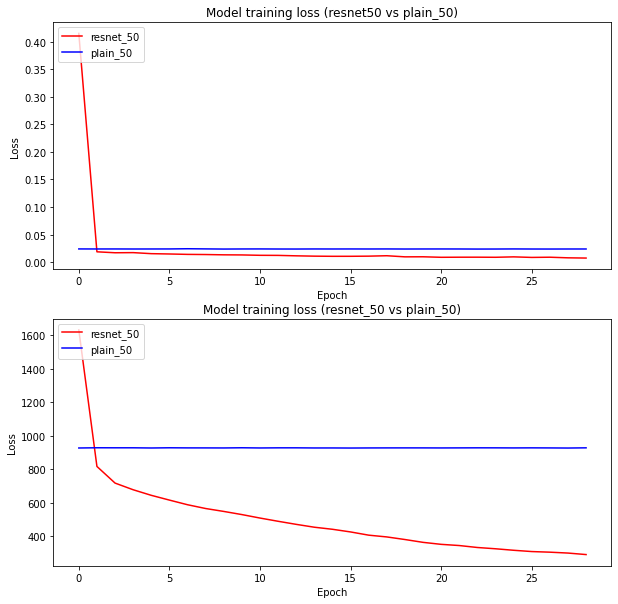

In [237]:
import matplotlib.pyplot as plt


# R 50 vs P 50 train loss, test loss 

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(loss_history["R50_val"], 'r')
plt.plot(loss_history["P50_val"], 'b')
plt.title('Model training loss (resnet50 vs plain_50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(loss_history["R50_train"], 'r')
plt.plot(loss_history["P50_train"], 'b')
plt.title('Model training loss (resnet_50 vs plain_50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.show()

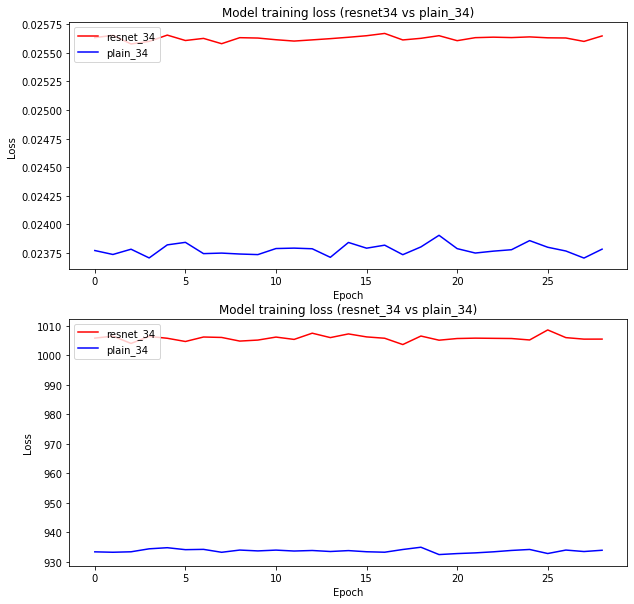

In [238]:
# R34 vs P 34
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(loss_history["R34_val"], 'r')
plt.plot(loss_history["P34_val"], 'b')
plt.title('Model training loss (resnet34 vs plain_34)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(loss_history["R34_train"], 'r')
plt.plot(loss_history["P34_train"], 'b')
plt.title('Model training loss (resnet_34 vs plain_34)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.show()

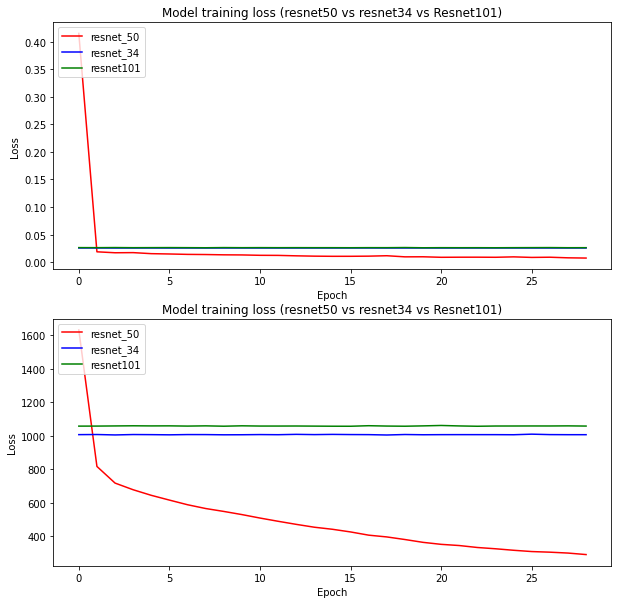

In [239]:
# R 50 vs R34 vs R101
# R34 vs P 34
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(loss_history["R50_val"], 'r')
plt.plot(loss_history["R34_val"], 'b')
plt.plot(loss_history["R101_val"], 'g')
plt.title('Model training loss (resnet50 vs resnet34 vs Resnet101)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'resnet_34',"resnet101"], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(loss_history["R50_train"], 'r')
plt.plot(loss_history["R34_train"], 'b')
plt.plot(loss_history["R101_train"], 'g')
plt.title('Model training loss (resnet50 vs resnet34 vs Resnet101)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'resnet_34',"resnet101"], loc='upper left')

plt.show()

# 회고

파이토치 이해하고 하는거 처음이라서 어려웠다 
그리고 34 , 50 블럭 부분 통합하려 했는 블럭내용이 달라서 결국 따로분리 했다 

augmentation할때 mix up cutmix등 넣고 싶었지만 아직 익숙지 않아서 결국 못넣었는데 
추후에 넣고 돌리고 싶다 
생각보다 학습 시간이 오래 걸렸다 

비교 내용 작성 
비교 결과 resnet 50이 가장 좋았다.. resnet 34,plain 34, plain 50 심지어 resnet 101도 결과가 좋지 않았다 아마도 epoch을 작게 돌려서 잘 확인 못한것도 있는것 같긴하지만 정확한 이유는 모르겠다




시간이 있었으면 validatian도 구분해서 하는건데 train 과 test만 분리 하고 
그래프 비교한게 조금 아쉽다.  그리고 시간이 없어서 30 에폭 만큼 밖에 못돌려 봤는데 
150에폭 200에폭 돌렸더라면 더 좋은 결과를 볼수있었을것 같다 시간이 되면 
나중에 해보겠다 